In [1]:
from pathlib import Path
import pandas as pd
from collections import defaultdict

from sqlalchemy import bindparam

from analysis.database import get_engine, PublicationROBType, PublicationType

In [2]:
with get_engine() as engine:
    all_pubs = pd.read_sql("SELECT * FROM publication ORDER BY publication_id",
                           engine)

all_pubs.head()

,publication_id,title,first_author,reference,doi,year,created_at,updated_at,publication_type_id,rob_publication_type_id
0,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,None,10.1161/CIRCEP.112.970517,2012,2024-08-07 14:42:25.465781+00:00,2024-08-07 14:47:19.255467+00:00,None,None
1,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",None,10.1016/j.jacc.2011.01.026,2011,2024-08-07 14:42:25.503383+00:00,2024-08-07 14:47:19.255467+00:00,None,None
2,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",None,10.1016/j.jacep.2020.03.006,2020,2024-08-07 14:42:25.533776+00:00,2024-08-07 14:47:19.255467+00:00,None,None
3,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",None,10.1253/circj.cj-12-1460,2013,2024-08-07 14:42:25.555177+00:00,2024-08-07 14:47:19.255467+00:00,None,None
4,5,Gender differences in the inheritance mode of ...,"Ohno, S.",None,10.1371/journal.pone.0131517,2015,2024-08-07 14:42:25.585543+00:00,2024-08-07 14:47:19.255467+00:00,None,None


In [7]:
# check if all pubs unique
encountered_ids = defaultdict(list)

all_publications = Path("data_commit/rob_analysis").rglob("*.xlsx")

for pub in all_publications:
    # if publication is rob_table_contents then skip
    if "rob_table_contents" in pub.stem:
        continue

    print(pub)
    df = pd.read_excel(pub)

    for pub_id in df["publication_id"]:
        encountered_ids[pub_id].append(pub.name)

        if len(encountered_ids[pub_id]) > 1:
            print(
                f"Publication {pub_id} encountered in {encountered_ids[pub_id]}")


data_commit/rob_analysis/rob_case_series.xlsx
data_commit/rob_analysis/others.xlsx
data_commit/rob_analysis/rob_cohort.xlsx
data_commit/rob_analysis/rob_case_control.xlsx
data_commit/rob_analysis/rob_diagnostic_accuracy.xlsx
data_commit/rob_analysis/rob_case_report.xlsx


In [8]:
set(encountered_ids.keys()) - set(all_pubs["publication_id"])

set()

In [9]:
not_analyzed = set(all_pubs["publication_id"]) - set(encountered_ids.keys())

all_pubs[all_pubs["publication_id"].isin(list(not_analyzed))]

,publication_id,title,first_author,reference,doi,year,created_at,updated_at,publication_type_id,rob_publication_type_id


## Insert Publication Others

In [10]:
# all pubs analyzed are in the db and all db papers have been analyzed (or marked as not analyzed)
others_df = pd.read_excel("data_commit/rob_analysis/others.xlsx")

others_df.head()

,publication_id,title,first_author,doi,resource_uri,doi_hyperlink,is_abstract,rob_publcation_class,publication_class
0,40,Denaturing HPLC-based approach for detecting R...,"Bagattin, A",10.1373/clinchem.2003.030734,https://pubmed.ncbi.nlm.nih.gov/15131021,https://doi.org/10.1373/clinchem.2003.030734,False,6,5
1,147,Flecainide prevents catecholaminergic polymorp...,"Watanabe, H",10.1038/nm.1942,https://pubmed.ncbi.nlm.nih.gov/19330009,https://doi.org/10.1038/nm.1942,False,6,4
2,148,Catecholaminergic polymorphic ventricular tach...,"van der Werf, C.",10.1136/heartjnl-2012-302033,https://pubmed.ncbi.nlm.nih.gov/23390049,https://doi.org/10.1136/heartjnl-2012-302033,False,7,6
3,157,Dantrolene rescues arrhythmogenic RYR2 defect ...,"Jung, CB",10.1002/emmm.201100194,https://pubmed.ncbi.nlm.nih.gov/22174035,https://doi.org/10.1002/emmm.201100194,False,6,5
4,192,Exome Analyses of Long QT Syndrome Reveal Cand...,Shigemizu D,10.1371/journal.pone.0130329,https://pubmed.ncbi.nlm.nih.gov/26132555,https://doi.org/10.1371/journal.pone.0130329,False,10,5


In [15]:
import sqlalchemy as sa

with get_engine() as engine:
    with engine.connect() as conn:
        for _, row in others_df.iterrows():
            conn.execute(
                sa.text(
                    """
                    UPDATE publication
                    SET publication_type_id = :pub_type_id,
                    rob_publication_type_id = :rob_pub_type_id
                    WHERE publication_id = :pub_id
                    """
                ),
                parameters={
                    "pub_type_id": row["publication_class"],
                    "rob_pub_type_id": row["rob_publcation_class"],
                    "pub_id": row["publication_id"]
                }
            )

        conn.commit()

with get_engine() as engine:
    pubs_others = pd.read_sql(sa.text("""
        SELECT p.publication_id, pt.publication_type, rpt.rob_publication_type
        FROM publication p
        LEFT JOIN publication_rob_type rpt ON p.rob_publication_type_id = rpt.rob_publication_type_id
        LEFT JOIN publication_type pt ON p.publication_type_id = pt.publication_type_id
        WHERE p.publication_id IN :pub_ids
        ORDER BY p.publication_id
        """).bindparams(
        bindparam("pub_ids", expanding=True)
    ), engine, params={"pub_ids": list(others_df["publication_id"])})

pubs_others

,publication_id,publication_type,rob_publication_type
0,4,Article,Genetic Association
1,40,Article,Basic Science
2,147,Brief Communication,Basic Science
3,148,Review,Systematic Review
4,157,Article,Basic Science
5,192,Article,Genetic Association
6,549,Article,Basic Science
7,632,Article,Basic Science
8,707,Article,Basic Science
9,769,Conference / Poster Abstract,Basic Science


In [16]:
case_control_df = pd.read_excel(
    "data_commit/rob_analysis/rob_case_control.xlsx")

case_control_df.head()

,publication_id,title,first_author,doi,resource_uri,doi_hyperlink,is_abstract,publication_class,1. Was the research question or objective in this paper clearly stated and appropriate?,2. Was the study population clearly specified and defined?,3. Did the authors include a sample size justification?,4. Were controls selected or recruited from the same or similar population that gave rise to the cases (including the same timeframe)?,"5. Were the definitions, inclusion and exclusion criteria, algorithms or processes used to identify or select cases and controls valid, reliable, and implemented consistently across all study participants?",6. Were the cases clearly defined and differentiated from controls?,"7. If less than 100 percent of eligible cases and/or controls were selected for the study, were the cases and/or controls randomly selected from those eligible?",8. Was there use of concurrent controls?,9. Were the investigators able to confirm that the exposure/risk occurred prior to the development of the condition or event that defined a participant as a case?,"10. Were the measures of exposure/risk clearly defined, valid, reliable, and implemented consistently (including the same time period) across all study participants?",11. Were the assessors of exposure/risk blinded to the case or control status of participants?,"12. Were key potential confounding variables measured and adjusted statistically in the analyses? If matching was used, did the investigators account for matching during study analysis?"
0,59,Mutations of the Cardiac Ryanodine Receptor (R...,Laitinen PJ,10.1161/01.CIR.103.4.485,https://pubmed.ncbi.nlm.nih.gov/11157710,https://doi.org/10.1161/01.CIR.103.4.485,False,5,YES,YES,NO,YES,CD,YES,NaN,NO,YES,YES,NO,NO
1,80,Molecular genetics of exercise-induced polymor...,Laitinen PJ,10.1038/sj.ejhg.5201061,https://pubmed.ncbi.nlm.nih.gov/14571276,https://doi.org/10.1038/sj.ejhg.5201061,False,4,YES,YES,NO,YES,CD,YES,NaN,NO,YES,YES,NO,NO
2,109,Cardiac genetic disposition in sudden infant d...,"Tester, D.J.",10.1016/j.jacc.2018.01.030,https://pubmed.ncbi.nlm.nih.gov/29544605,https://doi.org/10.1016/j.jacc.2018.01.030,False,5,YES,YES,NO,NO,YES,YES,NaN,NO,YES,YES,NO,NO
3,116,Utility of post-mortem genetic testing in case...,"Lahrouchi, N.",10.1016/j.jacc.2017.02.046,https://pubmed.ncbi.nlm.nih.gov/28449774,https://doi.org/10.1016/j.jacc.2017.02.046,False,5,YES,YES,NO,NO,YES,YES,NaN,NO,YES,YES,NO,YES
4,712,Genetic analysis of hyperemesis gravidarum rev...,"Fejzo, MS",10.1016/j.mce.2016.09.017,https://pubmed.ncbi.nlm.nih.gov/27663074,https://doi.org/10.1016/j.mce.2016.09.017,False,5,YES,YES,NO,YES,YES,YES,NaN,NO,YES,YES,NM,NM


In [19]:
case_series_df = pd.read_excel(
    "data_commit/rob_analysis/rob_case_series.xlsx"
)

case_series_df.head()

,publication_id,title,first_author,doi,resource_uri,doi_hyperlink,rob_publcation_class,is_abstract,publication_class,1. Was the study question or objective clearly stated?,"2. Was the study population clearly and fully described, including a case definition?",3. Were the cases consecutive?,4. Were the subjects comparable?,5. Was the intervention clearly described?,"6. Were the outcome measures clearly defined, valid, reliable, and implemented consistently across all study participants?",7. Was the length of follow-up adequate?,8. Were the statistical methods well-described?,9. Were the results well-described?
0,5,Gender differences in the inheritance mode of ...,"Ohno, S.",10.1371/journal.pone.0131517,https://pubmed.ncbi.nlm.nih.gov/26114861,https://doi.org/10.1371/journal.pone.0131517,12.0,False,5,YES,YES,NO,YES,NO,CD,YES,YES,YES
1,8,Refractory tachyarrhythmias caused by ryanodin...,"Nozaki, Y.",NaN,https://www.embase.com/records?id=L71893770,NaN,NaN,True,1,NO,NO,NO,YES,NO,NO,CD,NO,NO
2,24,Familial dilated cardiomyopathy associated wit...,NaN,10.5603/CJ.a2020.0099,https://pubmed.ncbi.nlm.nih.gov/32748945,https://doi.org/10.5603/CJ.a2020.0099,NaN,False,5,YES,YES,NO,YES,YES,YES,YES,NM,YES
3,27,Clinical characteristics and mutational analys...,"Andrsova, I.",10.1111/j.1540-8159.2012.03399.x,https://pubmed.ncbi.nlm.nih.gov/22519458,https://doi.org/10.1111/j.1540-8159.2012.03399.x,NaN,False,5,YES,YES,CD,YES,YES,YES,YES,NM,YES
4,28,Genetic characterization of familial CPVT afte...,"Beery, TA",10.1177/1099800409333369,https://pubmed.ncbi.nlm.nih.gov/19398417,https://doi.org/10.1177/1099800409333369,NaN,False,5,YES,YES,CD,YES,YES,YES,YES,YES,YES


In [22]:
with get_engine() as engine:
    with engine.connect() as conn:
        for pub in Path("data_commit/rob_analysis").rglob("rob_*.xlsx"):

            pub_type = pub.stem.split("rob_")[-1].replace("_", " ")

            rob_pub_type_id = conn.execute(sa.text("""
                SELECT rob_publication_type_id
                FROM publication_rob_type
                WHERE rob_publication_type ILIKE '%' || :pub_type || '%'
            """), {"pub_type": pub_type}).fetchall()

            if len(rob_pub_type_id) != 1 and len(rob_pub_type_id[0]) != 1:
                raise ValueError(f"Publication type {pub_type} not found")

            rob_pub_type_id_val = rob_pub_type_id[0][0]

            print(f"Publication type {pub_type} has id {rob_pub_type_id_val}")

            df = pd.read_excel(pub)

            for _, row in df.iterrows():

                if "rob_publcation_class" not in row or pd.isna(row[
                                                                    "rob_publcation_class"]):
                    pub_type_id = rob_pub_type_id_val
                else:
                    pub_type_id = row["rob_publcation_class"]

                conn.execute(
                    sa.text(
                        """
                        UPDATE publication
                        SET publication_type_id = :pub_type_id,
                        rob_publication_type_id = :rob_pub_type_id
                        WHERE publication_id = :pub_id
                        """
                    ),
                    parameters={
                        "pub_type_id": row["publication_class"],
                        "rob_pub_type_id": pub_type_id,
                        "pub_id": row["publication_id"]
                    }
                )

        conn.commit()

# CASE_CONTROL_ID = 4
#
# with get_engine() as engine:
#     with engine.connect() as conn:
#         case_control_id = conn.execute(sa.text("""
#         SELECT rob_publication_type_id
#         FROM publication_rob_type
#         WHERE rob_publication_type ILIKE '%case control%'
#         """)).fetchall()
#         print(case_control_id)
#


Publication type case series has id 3
Publication type cohort has id 1
Publication type case control has id 4
Publication type diagnostic accuracy has id 5
Publication type case report has id 2


In [23]:
publications_df_after = pd.read_sql(sa.text("""
    SELECT p.publication_id, pt.publication_type, rpt.rob_publication_type
    FROM publication p
    LEFT JOIN publication_rob_type rpt ON p.rob_publication_type_id = rpt.rob_publication_type_id
    LEFT JOIN publication_type pt ON p.publication_type_id = pt.publication_type_id
    ORDER BY p.publication_id
"""
                                            ), engine)

publications_df_after.head()


,publication_id,publication_type,rob_publication_type
0,1,Article,Cohort or Cross-Sectional Like Study
1,2,Article,Cohort or Cross-Sectional Like Study
2,3,Research Letter,Cohort or Cross-Sectional Like Study
3,4,Article,Genetic Association
4,5,Article,Case Only


In [24]:
# see if any are null
publications_df_after[publications_df_after["rob_publication_type"].isna() |
                      publications_df_after["publication_type"].isna()]

,publication_id,publication_type,rob_publication_type


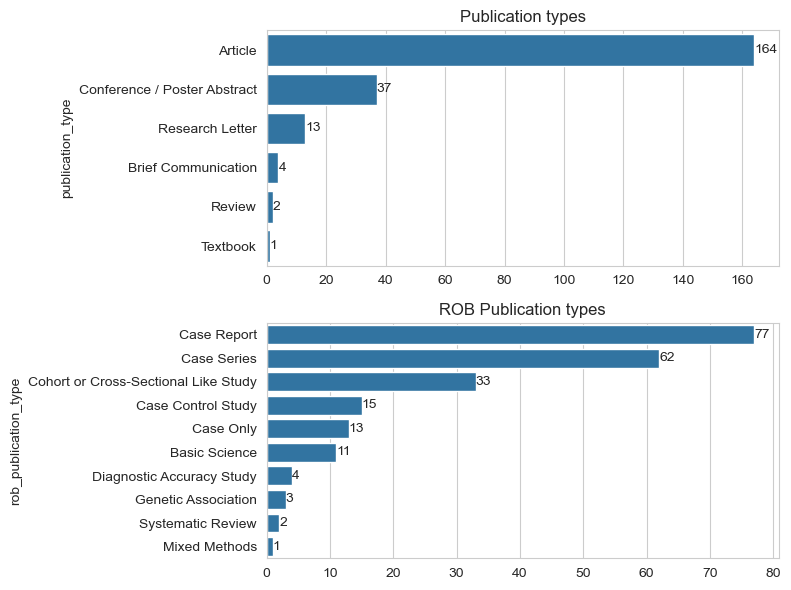

In [25]:
# barchart of publication types
import matplotlib.pyplot as plt
import seaborn as sns

pub_types = publications_df_after["publication_type"].value_counts()
rob_pub_types = publications_df_after["rob_publication_type"].value_counts()

fig, ax = plt.subplots(2, 1, figsize=(8, 6))

sns.barplot(
    y=pub_types.index,
    x=pub_types.values,
    ax=ax[0],
)
ax[0].bar_label(ax[0].containers[0], fontsize=10)
ax[0].set_title("Publication types")

sns.barplot(
    y=rob_pub_types.index,
    x=rob_pub_types.values,
    ax=ax[1]
)
ax[1].bar_label(ax[1].containers[0], fontsize=10)
ax[1].set_title("ROB Publication types")

plt.tight_layout()
